# SSL e HAR

In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

# Define constants
SAMPLING_RATE = 50  # Hz
WINDOW_SIZE = 2  # seconds
WINDOW_SAMPLES = int(WINDOW_SIZE * SAMPLING_RATE)

# Generate dummy data
np.random.seed(0)
walking_signal = np.random.normal(0, 1, size=10*60*SAMPLING_RATE)  # 10 minutes of walking data
running_signal = np.random.normal(0, 2, size=10*60*SAMPLING_RATE)  # 10 minutes of running data

# Split data into training and testing sets
train_walking_signal = walking_signal[:len(walking_signal)//2]
test_walking_signal = walking_signal[len(walking_signal)//2:]
train_running_signal = running_signal[:len(running_signal)//2]
test_running_signal = running_signal[len(running_signal)//2:]

# Define pitch estimator function using autocorrelation method
def estimate_pitch(signal):
    autocorrelation = np.correlate(signal, signal, mode='full')[len(signal)-1:]
    autocorrelation = autocorrelation / autocorrelation[0]
    min_indices = np.where((autocorrelation[1:-1] < autocorrelation[:-2]) & (autocorrelation[1:-1] < autocorrelation[2:]))[0] + 1
    if len(min_indices) > 0:
        min_index = min_indices[0]
        pitch = SAMPLING_RATE / min_index
    else:
        pitch = 0
    return pitch

# Prepare training data
def prepare_data(signal, label):
    data = []
    labels = []
    pitches = []
    for i in range(0, len(signal), WINDOW_SAMPLES):
        window = signal[i:i+WINDOW_SAMPLES]
        if len(window) == WINDOW_SAMPLES:
            data.append(window)
            labels.append(label)
            pitches.append(estimate_pitch(window))
    return np.array(data), np.array(labels), np.array(pitches)

train_walking_data, train_walking_labels, train_walking_pitches = prepare_data(train_walking_signal, 0)
train_running_data, train_running_labels, train_running_pitches = prepare_data(train_running_signal, 1)
train_data = np.concatenate((train_walking_data, train_running_data))
train_labels = np.concatenate((train_walking_labels, train_running_labels))
train_pitches = np.concatenate((train_walking_pitches, train_running_pitches))

test_walking_data, test_walking_labels, test_walking_pitches = prepare_data(test_walking_signal, 0)
test_running_data, test_running_labels, test_running_pitches = prepare_data(test_running_signal, 1)
test_data = np.concatenate((test_walking_data, test_running_data))
test_labels = np.concatenate((test_walking_labels, test_running_labels))
test_pitches = np.concatenate((test_walking_pitches, test_running_pitches))

# Define SSL model
input_layer = Input(shape=(WINDOW_SAMPLES,), name='input_layer')
x = Dense(128, activation='relu', name='dense1')(input_layer)
x = Dense(64, activation='relu', name='dense2')(x)
x = Dense(32, activation='relu', name='dense3')(x)
output_layer = Dense(1, name='output_layer')(x)
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(train_data, train_pitches, epochs=10, batch_size=32, validation_data=(test_data, test_pitches))

# Evaluate model
mse = model.evaluate(test_data, test_pitches)
print(f'MSE: {mse}')

Epoch 1/10
10/10 [==============================] - 1s 26ms/step - loss: 1182.2075 - val_loss: 1093.0494
Epoch 2/10
10/10 [==============================] - 0s 9ms/step - loss: 859.1806 - val_loss: 702.7211
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 503.9068 - val_loss: 385.5668
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 349.5419 - val_loss: 367.1903
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 322.5425 - val_loss: 358.8910
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 274.5451 - val_loss: 361.0059
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 248.5624 - val_loss: 359.8575
Epoch 8/10
10/10 [==============================] - 0s 10ms/step - loss: 225.6363 - val_loss: 365.0185
Epoch 9/10
10/10 [==============================] - 0s 10ms/step - loss: 207.3692 - val_loss: 366.0076
Epoch 10/10
10/10 [==============================] - 0s 3ms/step - loss: 370.

In [16]:
import numpy as np
import plotly.graph_objects as go
from scipy.signal import lfilter

# Function to generate noisy sinusoidal data
def generate_noisy_sinusoid(frequency, sampling_rate, duration, noise_std_dev=0.01):
    time = np.arange(0, duration, 1/sampling_rate)
    frequency_noisy = frequency + np.random.normal(0, noise_std_dev, size=len(time))
    signal = np.sin(2 * np.pi * frequency_noisy * time)
    signal += np.random.normal(0, noise_std_dev, size=len(time))
    return signal

# Function to estimate pitch using autocorrelation
def estimate_pitch(signal, sampling_rate):
    def autocorrelate(signal):
        result = np.convolve(signal, signal[::-1], mode='full')
        return result[len(result)//2:]

    autocorrelation = autocorrelate(signal)
    peaks = np.diff(np.sign(np.diff(autocorrelation)))
    peak_indices = np.where(peaks < 0)[0] + 1
    if len(peak_indices) > 1:
        peak_index = peak_indices[1]  # Ignore the first peak at index 0
        pitch = sampling_rate / peak_index
    else:
        pitch = 0
    return pitch

# Generate fake input data
np.random.seed(0)
sampling_rate = 50
duration = 600  # 10 minutes
walking_signal = generate_noisy_sinusoid(2, sampling_rate, duration)
running_signal = generate_noisy_sinusoid(4, sampling_rate, duration)

# Plot a signal of both classes showing the pitch estimate
window_size = 2 * sampling_rate  # 2-second window
walking_window = walking_signal[:window_size]
running_window = running_signal[:window_size]

walking_pitch = estimate_pitch(walking_window, sampling_rate)
running_pitch = estimate_pitch(running_window, sampling_rate)

fig = go.Figure(data=[
    go.Scatter(x=np.arange(len(walking_window))/sampling_rate, y=walking_window, name='Walking'),
    go.Scatter(x=np.arange(len(running_window))/sampling_rate, y=running_window, name='Running')
])
fig.update_layout(title=f'Walking Pitch: {walking_pitch:.2f} Hz, Running Pitch: {running_pitch:.2f} Hz',
                  xaxis_title='Time (s)', yaxis_title='Acceleration')
fig.show()

In [17]:
def autocorrelate(signal):
    result = np.convolve(signal, signal[::-1], mode='full')
    return result[len(result)//2:]

autocorrelation = autocorrelate(walking_window)
# peaks = np.diff(np.sign(np.diff(autocorrelation)))
# peak_indices = np.where(peaks < 0)[0] + 1

In [21]:
px.line(np.diff(np.sign(np.diff(autocorrelation))))

In [15]:
import numpy as np
import plotly.graph_objects as go
from scipy.signal import find_peaks

# Function to generate fake data
def generate_fake_data(frequency, sampling_rate, duration, noise_amplitude=0.1, noise_frequency=0.01):
    time = np.arange(0, duration, 1/sampling_rate)
    signal = np.sin(2 * np.pi * (frequency + noise_frequency * np.random.randn(len(time))) * time)
    signal *= 1 + noise_amplitude * np.random.randn(len(time))
    return signal

# Function to estimate pitch using autocorrelation method
def estimate_pitch(signal, sampling_rate):
    autocorrelation = np.correlate(signal, signal, mode='full')[len(signal)-1:]
    autocorrelation = autocorrelation / autocorrelation[0]
    peaks, _ = find_peaks(autocorrelation, height=0.5)
    if len(peaks) > 0:
        period = peaks[0]
        frequency = sampling_rate / period
        return frequency
    else:
        return 0

# Generate fake data
walking_signal = generate_fake_data(2, 50, 600)
running_signal = generate_fake_data(4, 50, 600)

# Split data into training and testing sets
walking_train, walking_test = walking_signal[:len(walking_signal)//2], walking_signal[len(walking_signal)//2:]
running_train, running_test = running_signal[:len(running_signal)//2], running_signal[len(running_signal)//2:]

# Estimate pitch for a 2-second window
window_size = 2 * 50  # 2 seconds * 50 Hz
walking_window = walking_signal[:window_size]
running_window = running_signal[:window_size]

walking_pitch = estimate_pitch(walking_window, 50)
running_pitch = estimate_pitch(running_window, 50)

# Plot signals with pitch estimate
fig = go.Figure(data=[
    go.Scatter(x=np.arange(len(walking_window))/50, y=walking_window, name='Walking'),
    go.Scatter(x=np.arange(len(running_window))/50, y=running_window, name='Running')
])

fig.update_layout(
    title='Signals with Pitch Estimate',
    xaxis_title='Time (s)',
    yaxis_title='Acceleration',
    annotations=[
        dict(x=0.5, y=1.1, text=f'Walking Pitch: {walking_pitch:.2f} Hz', showarrow=False),
        dict(x=0.5, y=1.05, text=f'Running Pitch: {running_pitch:.2f} Hz', showarrow=False)
    ]
)

fig.show()

In [4]:
import plotly.express as px

In [7]:
px.line(walking_signal)

In [11]:
def generate_fake_data(fs, duration, freq, noise_std_dev):
    # Time array
    t = np.arange(0, duration, 1/fs)

    # Noisy sinusoid
    freq_noisy = freq + np.random.normal(0, noise_std_dev, size=len(t))
    signal = np.sin(2 * np.pi * freq_noisy * t)

    # Add amplitude noise
    signal_noisy = signal + np.random.normal(0, noise_std_dev, size=len(t))

    return signal

# Parameters
fs = 50  # Sampling rate (Hz)
duration = 600  # Duration (s)
noise_std_dev = 0.001  # Standard deviation of the noise

# Generate fake data
walking_signal = generate_fake_data(fs, duration, 2, noise_std_dev)
running_signal = generate_fake_data(fs, duration, 4, noise_std_dev)
px.line(walking_signal)

# Fashion MNIST

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] /255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

'Coat'

In [ ]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.5))
history = stacked_ae.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Epoch 1/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3380 - val_loss: 0.3113
Epoch 2/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3064 - val_loss: 0.2985
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2995 - val_loss: 0.2936
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2953 - val_loss: 0.2914
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2927 - val_loss: 0.2904
Epoch 6/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2909 - val_loss: 0.2876
Epoch 7/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2895 - val_loss: 0.2869
Epoch 8/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2884 - val_loss: 0.2850
Epoch 9/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2872 - val_loss: 0.2843
Epoch 10/10
1719/1719 [==============================] - 13s 8ms/step - 

1/1 [==============================] - 0s 225ms/step


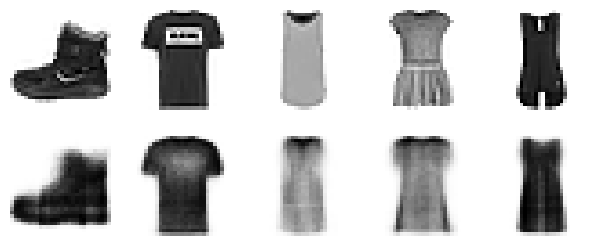

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
def show_reconstructions(model, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
show_reconstructions(stacked_ae)


# Proxima

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import pandas as pd

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

In [ ]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [ ]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

In [ ]:
pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import pandas as pd
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)
train_filepaths = save_to_multiple_csv_files(X_train, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(X_valid, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(X_test, "test", header, n_parts=10)
pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,NaN
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,NaN
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,NaN
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,NaN
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,NaN


In [ ]:
X_train.shape

(11610, 8)

In [ ]:
header

'MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue'

# Uma task

In [ ]:
import tensorflow as tf

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            tf.keras.layers.Conv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            tf.keras.layers.Conv2D(filters, 3, strides=1,
                                padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                tf.keras.layers.Conv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                tf.keras.layers.BatchNormalization()]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224,3],
                              padding="same", use_bias=False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (Batch  (None, 112, 112, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)        0         
 D)                                                              
                                                                 
 residual_unit (ResidualUni  (None, 56, 56, 64)        74240     
 t)                                                              
                                                        

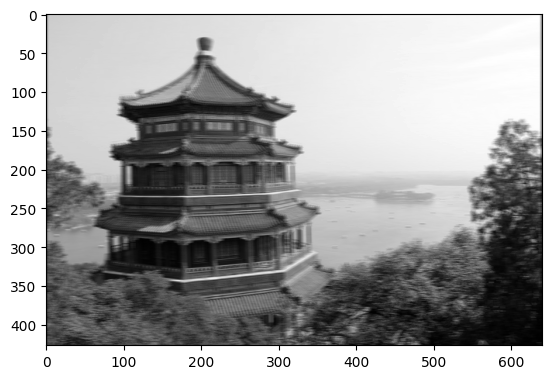

In [ ]:
from sklearn.datasets import load_sample_image
# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
# plt.imshow(images[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

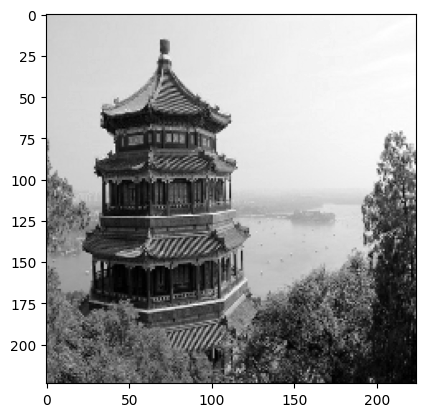

In [ ]:
plt.imshow(images_resized[0, :, :, 1], cmap="gray")
plt.show()

In [ ]:
images.shape

(2, 427, 640, 3)

In [ ]:
images_resized = tf.image.resize(images, [224, 224])

In [ ]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized * 255)

In [ ]:
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

# Resize the images to the expected size
images = tf.image.resize(images, (224, 224))

batch_size, height, width, channels = images.shape
Y_proba = model.predict(images)

1/1 [==============================] - 1s 884ms/step


In [ ]:
Y_proba = model.predict(images)

1/1 [==============================] - 0s 259ms/step


In [ ]:
Y_proba = model.predict(images_resized)

1/1 [==============================] - 1s 1s/step


In [ ]:
Y_proba

array([[0.03113894, 0.25322133, 0.21587616, 0.02666427, 0.0655633 ,
        0.05995285, 0.10753559, 0.06595758, 0.04556727, 0.12852281],
       [0.05339357, 0.19035506, 0.16835204, 0.0509965 , 0.07908782,
        0.07984128, 0.11080695, 0.08130628, 0.06515506, 0.12070555]],
      dtype=float32)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_sample_image

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            tf.keras.layers.Conv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            tf.keras.layers.Conv2D(filters, 3, strides=1,
                                padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                tf.keras.layers.Conv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                tf.keras.layers.BatchNormalization()]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224,3],
                              padding="same", use_bias=False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1000, activation="softmax"))

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

# Resize the images to the expected size
images = tf.image.resize(images, (224, 224))

Y_proba = model.predict(images)

# Display the top predictions for each image
for i, img in enumerate(images):
    top_predictions = tf.keras.applications.resnet50.decode_predictions(Y_proba[i].reshape(1, 1000), top=3)
    print(f"Top predictions for image {i+1}:")
    for prediction in top_predictions[0]:
        print(f"Class ID: {prediction[0]}, Class Name: {prediction[1]}, Confidence Score: {prediction[2]}")
    print()

35363/35363 [==============================] - 0s 0us/step
Top predictions for image 1:
Class ID: n02097047, Class Name: miniature_schnauzer, Confidence Score: 0.0020503278356045485
Class ID: n02454379, Class Name: armadillo, Confidence Score: 0.0019850688986480236
Class ID: n03028079, Class Name: church, Confidence Score: 0.0018951970851048827

Top predictions for image 2:
Class ID: n02097047, Class Name: miniature_schnauzer, Confidence Score: 0.0015043029561638832
Class ID: n02454379, Class Name: armadillo, Confidence Score: 0.0014993580989539623
Class ID: n03028079, Class Name: church, Confidence Score: 0.0014568620827049017



In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_sample_image
from tensorflow.keras.applications.resnet50 import decode_predictions

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            tf.keras.layers.Conv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            tf.keras.layers.Conv2D(filters, 3, strides=1,
                                padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                tf.keras.layers.Conv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                tf.keras.layers.BatchNormalization()]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224,3],
                              padding="same", use_bias=False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1000, activation="softmax"))  # Update the number of classes to 1000

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

# Resize the images to the expected size
images = tf.image.resize(images, (224, 224))

# Expand the dimensions to include the batch size
images = tf.expand_dims(images, axis=0)
images = tf.reshape(images, (-1, 224, 224, 3))

# Make predictions
Y_proba = model.predict(images)

# Decode the predictions
decoded_predictions = decode_predictions(Y_proba, top=3)

# Display the top predictions
for i, predictions in enumerate(decoded_predictions):
    print(f"Image {i+1}:")
    for (class_id, class_name, confidence) in predictions:
        print(f"  - {class_name}: {confidence:.2f}")

1/1 [==============================] - 2s 2s/step
Image 1:
  - vine_snake: 0.00
  - minibus: 0.00
  - water_tower: 0.00
Image 2:
  - vine_snake: 0.00
  - minibus: 0.00
  - leopard: 0.00


In [ ]:
for i, predictions in enumerate(decoded_predictions):
    print(f"Image {i+1}:")
    for (class_id, class_name, confidence) in predictions:
        print(class_id, class_name, confidence)

Image 1:
n01739381 vine_snake 0.0021510571
n03769881 minibus 0.0018348855
n04562935 water_tower 0.0017694039
Image 2:
n01739381 vine_snake 0.0015683078
n03769881 minibus 0.0014392494
n02128385 leopard 0.0014221048


In [ ]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print(" {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (2, 10)

# Outra task

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import time
import threading

class PetCareScheduler:
    def __init__(self, pet_name):
        self.pet_name = pet_name
        self.tasks = {}
        self.logs = []
        self.reminders = []

    def add_task(self, task_name, time, frequency):
        self.tasks[task_name] = {"time": time, "frequency": frequency}
        self.reminders.append((task_name, time))

    def view_tasks(self):
        print(f"Tasks for {self.pet_name}:")
        for task, details in self.tasks.items():
            print(f"{task}: {details['time']} - {details['frequency']}")

    def log_event(self, event):
        self.logs.append({"date": datetime.now().strftime("%Y-%m-%d"), "event": event})

    def view_logs(self):
        print(f"Logs for {self.pet_name}:")
        for log in self.logs:
            print(f"{log['date']}: {log['event']}")

    def export_to_csv(self):
        # Create a weekly table with two hour slots
        table = []
        for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]:
            row = [day]
            for hour in range(8, 20, 2):
                slot = f"{hour}:00"
                tasks = [task for task, details in self.tasks.items() if details["time"] == slot]
                row.append(", ".join(tasks))
            table.append(row)

        df = pd.DataFrame(table, columns=["Day"] + [f"{hour}:00" for hour in range(8, 20, 2)])
        print(df)
        df.to_csv(f"{self.pet_name}_routine.csv", index=False)

        logs_df = pd.DataFrame(self.logs)
        logs_df.to_csv(f"{self.pet_name}_logs.csv", index=False)

    def start_reminders(self):
        def check_reminders():
            while True:
                current_time = datetime.now().strftime("%H:%M")
                for task, time in self.reminders:
                    reminder_time = (datetime.strptime(time, "%I:%M %p") - timedelta(minutes=30)).strftime("%H:%M")
                    if current_time == reminder_time:
                        print(f"Reminder: {task} at {time}")
                time.sleep(60)

        threading.Thread(target=check_reminders).start()


# Example usage
scheduler = PetCareScheduler("Homer")

scheduler.add_task("Feeding", "8:00 AM", "Daily")
scheduler.add_task("Walking", "12:00 PM", "Daily")
scheduler.add_task("Grooming", "3:00 PM", "Weekly")
scheduler.add_task("Vet Visit", "10:00 AM", "Monthly")

scheduler.view_tasks()

scheduler.log_event("Homer ate his food enthusiastically today.")
scheduler.log_event("Homer seemed a bit lethargic during the walk today.")

scheduler.view_logs()

scheduler.export_to_csv()

scheduler.start_reminders()

Tasks for Homer:
Feeding: 8:00 AM - Daily
Walking: 12:00 PM - Daily
Grooming: 3:00 PM - Weekly
Vet Visit: 10:00 AM - Monthly
Logs for Homer:
2024-06-18: Homer ate his food enthusiastically today.
2024-06-18: Homer seemed a bit lethargic during the walk today.
         Day 8:00 10:00 12:00 14:00 16:00 18:00
0     Monday                                   
1    Tuesday                                   
2  Wednesday                                   
3   Thursday                                   
4     Friday                                   
5   Saturday                                   
6     Sunday                                   


Exception in thread Thread-39 (check_reminders):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-20-61e13a245634>", line 56, in check_reminders
AttributeError: 'str' object has no attribute 'sleep'


In [ ]:
for hour in range(8, 20, 2):
    slot = f"{hour}:00 AM"
    for task, details in scheduler.tasks.items():
        print(details['time'], slot, details['time']==slot)

8:00 AM 8:00 AM True
12:00 PM 8:00 AM False
3:00 PM 8:00 AM False
10:00 AM 8:00 AM False
8:00 AM 10:00 AM False
12:00 PM 10:00 AM False
3:00 PM 10:00 AM False
10:00 AM 10:00 AM True
8:00 AM 12:00 AM False
12:00 PM 12:00 AM False
3:00 PM 12:00 AM False
10:00 AM 12:00 AM False
8:00 AM 14:00 AM False
12:00 PM 14:00 AM False
3:00 PM 14:00 AM False
10:00 AM 14:00 AM False
8:00 AM 16:00 AM False
12:00 PM 16:00 AM False
3:00 PM 16:00 AM False
10:00 AM 16:00 AM False
8:00 AM 18:00 AM False
12:00 PM 18:00 AM False
3:00 PM 18:00 AM False
10:00 AM 18:00 AM False


In [ ]:

table = []
for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]:
    row = [day]
    for hour in range(8, 20, 2):
        slot = f"{hour}:00"
        tasks = [task for task, details in scheduler.tasks.items() if details["time"] == slot]
        row.append(", ".join(tasks))
    table.append(row)

NameError: name 'table' is not defined

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import time
import threading

class PetCareScheduler:
    def __init__(self, pet_name):
        self.pet_name = pet_name
        self.tasks = {}
        self.logs = []
        self.reminders = []

    def add_task(self, task_name, time, frequency):
        self.tasks[task_name] = {"time": time, "frequency": frequency}
        self.schedule_reminder(task_name, time)

    def view_tasks(self):
        print(f"Tasks for {self.pet_name}:")
        for task, details in self.tasks.items():
            print(f"{task}: {details['time']} - {details['frequency']}")

    def log_event(self, event):
        self.logs.append({"date": datetime.now().strftime("%Y-%m-%d"), "event": event})

    def view_logs(self):
        print(f"Logs for {self.pet_name}:")
        for log in self.logs:
            print(f"{log['date']}: {log['event']}")

    def export_to_csv(self):
        # Create a weekly table with two hour slots from 8am to 8pm
        time_slots = [f"{hour}:00" for hour in range(8, 20, 2)]
        days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        weekly_table = pd.DataFrame(index=days, columns=time_slots)

        # Mark the pet routine on the respective slots
        for task, details in self.tasks.items():
            time_slot = details["time"].split(":")[0] + ":00"
            if details["frequency"] == "Daily":
                weekly_table[time_slot] = task
            elif details["frequency"] == "Weekly":
                weekly_table.loc["Monday", time_slot] = task
            elif details["frequency"] == "Monthly":
                weekly_table.loc["Monday", time_slot] = task  # Assuming monthly tasks are on the first Monday
        print(weekly_table)
        weekly_table.to_csv(f"{self.pet_name}_routine.csv", index_label="Day")

        # Export logs to CSV
        logs_df = pd.DataFrame(self.logs)
        logs_df.to_csv(f"{self.pet_name}_logs.csv", index=False)

    def schedule_reminder(self, task_name, time):
        reminder_time = datetime.strptime(time, "%I:%M %p") - timedelta(minutes=30)
        reminder_time = reminder_time.strftime("%I:%M %p")
        self.reminders.append((task_name, reminder_time))
        threading.Thread(target=self.remind, args=(task_name, reminder_time)).start()

    def remind(self, task_name, reminder_time):
        while True:
            current_time = datetime.now().strftime("%I:%M %p")
            if current_time == reminder_time:
                print(f"Reminder: {task_name} at {self.tasks[task_name]['time']}")
                break
            time.sleep(60)  # Check every minute


# Example usage
scheduler = PetCareScheduler("Homer")

scheduler.add_task("Feeding", "8:00 AM", "Daily")
scheduler.add_task("Walking", "12:00 PM", "Daily")
scheduler.add_task("Grooming", "3:00 PM", "Weekly")
scheduler.add_task("Vet Visit", "10:00 AM", "Monthly")

scheduler.view_tasks()

scheduler.log_event("Homer ate his food enthusiastically today.")
scheduler.log_event("Homer seemed a bit lethargic during the walk today.")

scheduler.view_logs()

scheduler.export_to_csv()

Tasks for Homer:
Feeding: 8:00 AM - Daily
Walking: 12:00 PM - Daily
Grooming: 3:00 PM - Weekly
Vet Visit: 10:00 AM - Monthly
Logs for Homer:
2024-06-18: Homer ate his food enthusiastically today.
2024-06-18: Homer seemed a bit lethargic during the walk today.
              8:00      10:00    12:00 14:00 16:00 18:00      3:00
Monday     Feeding  Vet Visit  Walking   NaN   NaN   NaN  Grooming
Tuesday    Feeding        NaN  Walking   NaN   NaN   NaN       NaN
Wednesday  Feeding        NaN  Walking   NaN   NaN   NaN       NaN
Thursday   Feeding        NaN  Walking   NaN   NaN   NaN       NaN
Friday     Feeding        NaN  Walking   NaN   NaN   NaN       NaN
Saturday   Feeding        NaN  Walking   NaN   NaN   NaN       NaN
Sunday     Feeding        NaN  Walking   NaN   NaN   NaN       NaN


# Mais uma

In [ ]:
pip install dash

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import time
import dash_daq as daq

# Generate fake triaxial accelerometer data
np.random.seed(0)
t = np.arange(0, 600, 0.02)  # 10 minutes of data at 50 Hz
x = np.sin(2 * np.pi * 7 * t) + np.random.normal(0, 0.1, len(t))
y = np.sin(2 * np.pi * 7 * t + np.pi / 2) + np.random.normal(0, 0.1, len(t))
z = np.sin(2 * np.pi * 7 * t + np.pi) + np.random.normal(0, 0.1, len(t))

# Create a DataFrame with the data
df = pd.DataFrame({'Time': t, 'X': x, 'Y': y, 'Z': z})

# Dash app
app = dash.Dash(__name__)

# Layout
app.layout = html.Div([
    html.H1('Real-time SPC Control Charts'),
    dcc.Interval(id='interval', interval=5000, n_intervals=0),  # Update every 5 seconds
    dcc.Graph(id='x-chart'),
    dcc.Graph(id='y-chart'),
    dcc.Graph(id='z-chart'),
    daq.BooleanSwitch(id='switch', on=False),
    html.Div(id='alarm')
])

# Update control charts
@app.callback([Output('x-chart', 'figure'),
               Output('y-chart', 'figure'),
               Output('z-chart', 'figure')],
              [Input('interval', 'n_intervals')])
def update_charts(n):
    # Get the last 50 seconds of data
    last_50_seconds = df[df['Time'] <= n * 5 + 50]

    # Calculate mean and standard deviation for each axis
    x_mean = last_50_seconds['X'].mean()
    x_std = last_50_seconds['X'].std()
    y_mean = last_50_seconds['Y'].mean()
    y_std = last_50_seconds['Y'].std()
    z_mean = last_50_seconds['Z'].mean()
    z_std = last_50_seconds['Z'].std()

    # Create control charts
    x_chart = go.Figure(data=[go.Scatter(x=last_50_seconds['Time'], y=last_50_seconds['X'], mode='lines')])
    x_chart.add_hline(y=x_mean, line_dash='dash', line_color='green')
    x_chart.add_hline(y=x_mean + 3 * x_std, line_dash='dash', line_color='red')
    x_chart.add_hline(y=x_mean - 3 * x_std, line_dash='dash', line_color='red')
    x_chart.update_layout(title='X Axis Control Chart')

    y_chart = go.Figure(data=[go.Scatter(x=last_50_seconds['Time'], y=last_50_seconds['Y'], mode='lines')])
    y_chart.add_hline(y=y_mean, line_dash='dash', line_color='green')
    y_chart.add_hline(y=y_mean + 3 * y_std, line_dash='dash', line_color='red')
    y_chart.add_hline(y=y_mean - 3 * y_std, line_dash='dash', line_color='red')
    y_chart.update_layout(title='Y Axis Control Chart')

    z_chart = go.Figure(data=[go.Scatter(x=last_50_seconds['Time'], y=last_50_seconds['Z'], mode='lines')])
    z_chart.add_hline(y=z_mean, line_dash='dash', line_color='green')
    z_chart.add_hline(y=z_mean + 3 * z_std, line_dash='dash', line_color='red')
    z_chart.add_hline(y=z_mean - 3 * z_std, line_dash='dash', line_color='red')
    z_chart.update_layout(title='Z Axis Control Chart')

    return x_chart, y_chart, z_chart

# Update alarm
@app.callback(Output('alarm', 'children'),
              [Input('switch', 'on')])
def update_alarm(on):
    if on:
        return 'Alarm is on!'
    else:
        return 'Alarm is off'

if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import dash_core_components as dcc
import plotly.graph_objects as go
import time
import random

# Generate fake triaxial accelerometer data
sample_rate = 50
time_step = 1 / sample_rate
duration = 10 * 60  # 10 minutes
t = np.arange(0, duration, time_step)
x = np.sin(2 * np.pi * 7 * t) + np.random.normal(0, 0.1, len(t))
y = np.sin(2 * np.pi * 7 * t + np.pi / 2) + np.random.normal(0, 0.1, len(t))
z = np.sin(2 * np.pi * 7 * t + np.pi) + np.random.normal(0, 0.1, len(t))

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    dcc.Graph(id='control-chart', animate=True),
    dcc.Interval(id='interval-component', interval=5000, n_intervals=0)  # Update every 5 seconds
])

# Define the callback function to update the control chart
@app.callback(Output('control-chart', 'figure'), [Input('interval-component', 'n_intervals')])
def update_control_chart(n):
    # Calculate the mean and standard deviation of each axis for the current timestamp
    current_time = n * 5  # Update every 5 seconds
    current_index = int(current_time * sample_rate)
    x_mean = np.mean(x[:current_index])
    x_std = np.std(x[:current_index])
    y_mean = np.mean(y[:current_index])
    y_std = np.std(y[:current_index])
    z_mean = np.mean(z[:current_index])
    z_std = np.std(z[:current_index])

    # Create the control chart figure
    fig = go.Figure(data=[
        go.Scatter(x=t[:current_index], y=x[:current_index], name='X Axis'),
        go.Scatter(x=t[:current_index], y=y[:current_index], name='Y Axis'),
        go.Scatter(x=t[:current_index], y=z[:current_index], name='Z Axis'),
        go.Scatter(x=[t[current_index-1]], y=[x_mean], name='X Mean', mode='markers'),
        go.Scatter(x=[t[current_index-1]], y=[y_mean], name='Y Mean', mode='markers'),
        go.Scatter(x=[t[current_index-1]], y=[z_mean], name='Z Mean', mode='markers'),
        go.Scatter(x=[t[current_index-1]], y=[x_mean + 3 * x_std], name='X UCL', mode='markers'),
        go.Scatter(x=[t[current_index-1]], y=[y_mean + 3 * y_std], name='Y UCL', mode='markers'),
        go.Scatter(x=[t[current_index-1]], y=[z_mean + 3 * z_std], name='Z UCL', mode='markers'),
        go.Scatter(x=[t[current_index-1]], y=[x_mean - 3 * x_std], name='X LCL', mode='markers'),
        go.Scatter(x=[t[current_index-1]], y=[y_mean - 3 * y_std], name='Y LCL', mode='markers'),
        go.Scatter(x=[t[current_index-1]], y=[z_mean - 3 * z_std], name='Z LCL', mode='markers')
    ])

    # Update the layout of the figure
    fig.update_layout(title='Triaxial Accelerometer Control Chart', xaxis_title='Time (s)', yaxis_title='Acceleration (g)')

    return fig

# Run the Dash app
if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>

In [ ]:
n = 4
current_time = n * 5  # Update every 5 seconds
current_index = int(current_time * sample_rate)
x_mean = np.mean(x[:current_index])
x_std = np.std(x[:current_index])
y_mean = np.mean(y[:current_index])
y_std = np.std(y[:current_index])
z_mean = np.mean(z[:current_index])
z_std = np.std(z[:current_index])
fig = go.Figure(data=[
        go.Scatter(x=t[:current_index], y=x[:current_index], name='X Axis'),
        go.Scatter(x=t[:current_index], y=y[:current_index], name='Y Axis'),
        go.Scatter(x=t[:current_index], y=z[:current_index], name='Z Axis'),
        go.Scatter(x=[t[current_index-1]], y=[x_mean], name='X Mean', mode='markers'),
        go.Scatter(x=[t[current_index-1]], y=[y_mean], name='Y Mean', mode='markers'),
        go.Scatter(x=[t[current_index-1]], y=[z_mean], name='Z Mean', mode='markers'),
        go.Scatter(x=[t[current_index-1]], y=[x_mean + 3 * x_std], name='X UCL', mode='markers'),
        go.Scatter(x=[t[current_index-1]], y=[y_mean + 3 * y_std], name='Y UCL', mode='markers'),
        go.Scatter(x=[t[current_index-1]], y=[z_mean + 3 * z_std], name='Z UCL', mode='markers'),
        go.Scatter(x=[t[current_index-1]], y=[x_mean - 3 * x_std], name='X LCL', mode='markers'),
        go.Scatter(x=[t[current_index-1]], y=[y_mean - 3 * y_std], name='Y LCL', mode='markers'),
        go.Scatter(x=[t[current_index-1]], y=[z_mean - 3 * z_std], name='Z LCL', mode='markers')
    ])
fig.show()

In [ ]:
px.line(x)